In [ ]:
#!git clone -b brian-etl-code https://github.com/The-Taimaka-Project/health-predictions.git
!git clone https://github.com/The-Taimaka-Project/health-predictions.git

In [ ]:
!pip install boto3 --quiet
!pip install autogluon --quiet

In [ ]:
import sys
#sys.path.append('/content/health-predictions/packages/inference/run')
sys.path.append('/content/health-predictions')


from packages.inference.run.globals import logger,MODEL_DIR, ETL_DIR
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from packages.inference.run.util import strip_column_names,DetnReaderWriter,split_detn_new_onset_medical_complication
from packages.inference.run.util import ag_feature_generator,lightgbm_train,select_features,drop_feature_columns
import matplotlib.pyplot as plt
from warnings import simplefilter
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from packages.inference.run.digitalocean import DigitalOceanStorage
import os
from google.colab import userdata


In [ ]:

os.environ["TAIMAKA_DO_ACCESS_KEY"] = userdata.get('TAIMAKA_DO_ACCESS_KEY')
os.environ["TAIMAKA_DO_SECRET_KEY"] = userdata.get('TAIMAKA_DO_SECRET_KEY')

do_storage = DigitalOceanStorage()

In [ ]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
simplefilter(action="ignore", category=RuntimeWarning)

# get the data

In [ ]:
detn_reader = DetnReaderWriter()
detn,label = detn_reader.read_new_onset_medical_complication()


In [ ]:
detn_admit_only,_,_,_ = split_detn_new_onset_medical_complication(detn,label)
pid_not_in_admit = detn[~detn['pid'].isin(detn_admit_only['pid'])]['pid']

# Get rows from detn where 'pid' is in pid_not_in_admit
detn_filtered = detn[detn['pid'].isin(pid_not_in_admit)].copy()


In [ ]:
columns_to_keep = {
    'b_referred_emergency',
'b_wast_admit',
'cg_age',
'enr_age',
'wk1_age',
'wk1_b_wast'
}
print( detn_filtered.shape)
detn_filtered = drop_feature_columns(detn_filtered,label,drop_muac=False,drop_weight=False,drop_height=False,columns_to_keep=columns_to_keep)
print( detn_filtered.shape)

In [ ]:
y_cat1_cols = [col for col in detn.columns if col.startswith('y_')]
y_cols = y_cat1_cols.copy()
y_cols.append(label)



# LightGBM iteration for feature selection

In [ ]:
# prompt: train test split admit_raw using column y_detn_ever as y
# Separate features (X) and target (y)

#X = detn_admit_only.drop(columns=y_cols)
#y = detn_admit_only[label]

X = detn_filtered.drop(columns=y_cols)
y = detn_filtered[label]


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



In [ ]:
X_train_transformed,X_test_transformed = ag_feature_generator(X_train,X_test)
#transformed = pd.concat([X_train_transformed.join(y_train),X_test_transformed.join(y_test)],axis=0)

In [ ]:
gbm,f1_scored,aic,top_features = lightgbm_train(X_train_transformed, X_test_transformed, y_train, y_test)
print(len(gbm.feature_name_),f1_scored)

X_train_transformed_top = X_train_transformed[top_features].copy()
X_test_transformed_top = X_test_transformed[top_features].copy()
gbm,f1_scored,aic,top_features = lightgbm_train(X_train_transformed_top, X_test_transformed_top, y_train, y_test)
print(len(gbm.feature_name_),f1_scored)

best_gbm,best_features,results_df,best_aic,features = select_features(gbm,X_train_transformed_top,X_test_transformed_top, y_train, y_test,30,0,-1)

# 808 0.9034267912772586
# 268 0.9192546583850931

In [ ]:
print(best_aic,'\n',best_features,len(best_features))
results_df.sort_values(by='AIC',ascending=True)

# f1 .899
#  ['wfh_rsquared' 'cg_weight' 'wfh_trend' 'hl_trend' 'weekly_avg_muac'
# 'admit_cat1_complications' 'wk2_wfaz' 'wfhz_admit' 'wk3_wfhz'
# 'wk1_resp_rate_weekly' 'weight_rsquared' 'hfa_trend' 'wk3_hfa_diff_rate'
# 'household_adults_slept_living_children_z' 'weight_trend' 'wk2_wfhz'
# 'wk1_rainy_season_weekly' 'hfa_rsquared' 'temperature']

In [ ]:
N_FEATURES = 13
print(N_FEATURES,features[N_FEATURES])


top_features = [col for col in strip_column_names(features[N_FEATURES]) if col in detn.columns]


In [ ]:
#top_features = ['hl_trend', 'weekly_avg_muac', 'wk2_muac', 'estdist_home', 'wk1_rainy_season_weekly', 'resp_rate', 'muac_trend', 'cat1_complications_weekly', 'household_adults_slept_living_children_z', 'muac_diff_ratio_z', 'muac_rsquared', 'muac_diff_ratio_rate', 'wk1_weight_diff_rate', 'wk1_resp_rate_weekly']

# AutoGluon Training

In [ ]:
# prompt: train test split admit_raw using column y_detn_ever as y

# Separate features (X) and target (y)

#X = detn_admit_only[top_features]
#y = detn_admit_only[label]

X = detn_filtered[top_features]
y = detn_filtered[label]
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43) # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
AG_PATH = f'AutogluonModels/{label}'
train_data = TabularDataset(X_train.join(y_train))
predictor = TabularPredictor(label=label,eval_metric='f1',path=AG_PATH).fit(train_data,time_limit=300,presets='medium_quality')
#predictor = TabularPredictor(label=label,eval_metric='f1',path=AG_PATH).fit(train_data,time_limit=600,presets='good_quality')


## evaluate AG model on holdout (i.e., test) data

In [ ]:
test_data2 = TabularDataset(X_test.join(y_test))
predictor.calibrate_decision_threshold()
y_pred = predictor.predict(test_data2.drop(columns=[label]))
print(predictor.evaluate(test_data2, silent=True))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(f1_score(y_test,y_pred))
# 0.1.0 is 0.8758782201405152

## feature importance

In [ ]:
autogluon_feature_importance = predictor.feature_importance(test_data2,subsample_size=1000,time_limit=400)
autogluon_feature_importance['cumsum'] = autogluon_feature_importance['importance'].cumsum()/autogluon_feature_importance['importance'].sum()
autogluon_feature_importance['importance_ratio'] = autogluon_feature_importance['importance']/autogluon_feature_importance['importance'].sum()
autogluon_feature_importance[['cumsum','importance_ratio']]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot on the primary y-axis
autogluon_feature_importance_filtered = autogluon_feature_importance[autogluon_feature_importance['importance']>0]
ax1.barh(autogluon_feature_importance_filtered.index, autogluon_feature_importance_filtered['importance_ratio'], label='Importance Ratio')
ax1.set_xlabel('Importance')
ax1.set_ylabel('Features')
ax1.set_title('Feature Importance with Cumulative Sum')
ax1.legend(loc='upper left') # specify location for the first legend
ax1.grid(True, axis='x') # gridlines only on the x-axis for the bar plot
ax1.invert_yaxis()

# Create a secondary y-axis
ax2 = ax1.twiny()

# Line plot on the secondary y-axis
ax2.plot(autogluon_feature_importance_filtered['cumsum'], autogluon_feature_importance_filtered.index, marker='o', linestyle='-', color='red', label='Cumulative Sum')
ax2.set_xlabel('Cumulative Sum')
ax2.legend(loc='upper right') # specify location for the second legend

# Improve layout
fig.tight_layout()
plt.show()


0.1.0 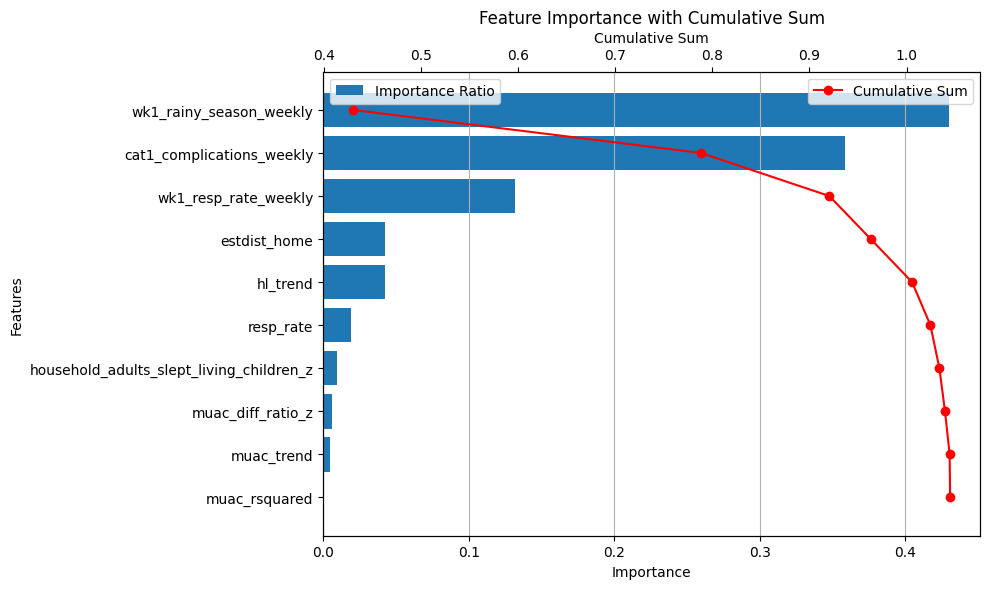

## export the AG model

In [ ]:
VERSION = "0.1.0"

metadata = {
    "version": VERSION,
    "inputs": autogluon_feature_importance.sort_values(by='importance',ascending=False).index.tolist(),
    "outputs": "chance of new onset medical complication, referral to inpatient treatment with a cat1 medical severity",
    "description": (
        "Predicts chance of new onset medical complication health complication  given the latest 3 weeks of patient weekly (raw and processed) data plus their admission data.  Medical complication is defined as a 'cat1' complication (see vars in raw ODK data with cat1_ prefix)"
    ),
    "feature_engineering": (
        "<household_adults_slept_living_children_z> is a one-dimension PCA reduction of the normalized values of ['household_adults','household_slept','living_children'] <muac_diff_ratio_z> is a similar reduction of ['muac_diff_ratio','muac'] which are muac change per day over the patient's treatment ((latest muac - first muac)/days in program) and their admittance muac"
    ),
    "contact": "Brian Chaplin",
}

path = f"{MODEL_DIR}{label}not1/{VERSION}/model.tar.gz"

do_storage.to_autogluon_tarball(predictor, model_metadata=metadata, path=path)

